# <strong> A - Importation de modules importants </strong>

Forcer tensorflow à utiliser le CPU

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [1]:
######################################################################################
import pandas as pd
import numpy as np
import spacy
from sklearn import metrics, preprocessing
from sklearn.preprocessing import RobustScaler
import re
######################################################################################

import tensorflow.keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout
from keras import optimizers
import tensorflow as tf

######################################################################################
import nltk
import re

######################################################################################
import import_ipynb
from Brice_KENGNI_ZANGUIM_2_1_script_functions_17_08_2022 import *
from Brice_KENGNI_ZANGUIM_2_5_script_UniversalSentenceEncoder_USE_17_08_2022 import USE_model

importing Jupyter notebook from Brice_KENGNI_ZANGUIM_2_1_script_functions_17_08_2022.ipynb
importing Jupyter notebook from Brice_KENGNI_ZANGUIM_2_5_script_UniversalSentenceEncoder_USE_17_08_2022.ipynb


# <strong> B - Chargement des données </strong>

In [2]:
nlp = spacy.load("en_core_web_sm")

In [3]:
data = {}
corpus = {}

for data_name in ["train_data", "test_data", "validation_data"] :
    data[data_name] = pd.read_csv(f"{data_name}_stem.csv")
    #idx = get_train_test_index( data[data_name] ,"labels" ,(150,2,2))
    #data[data_name].reset_index(inplace=False).reset_index(inplace=True)
    #data[data_name] = data[data_name].loc[idx[0],:]
    #print("ok 0")
    # Expression regulières
    #data[data_name].text = data[data_name].text.apply(lambda sent : re.sub('[^a-zA-Z.]|(?<!\d)\.|\.(?!\d)',' ',str(sent) ))
    #print("ok 1")
    # Mots courts
    #data[data_name].text = data[data_name].text.apply(lambda sent : " ".join([ i.text for i in nlp(sent) if len(i.text) > 2 ]))
    #print("ok 2")
    # Valeurs manquantes
    data[data_name].dropna(inplace=True)
    print("ok 3")
    #  Sauvegarde
    data[data_name].to_csv(f'{data_name}_stem.csv', index = False)
    
    # Corpus en forme de liste
    corpus[data_name] = [ i for i in data[data_name].text ]

ok 3
ok 3
ok 3


In [4]:
data["train_data"]

,labels,text
0,0,day
1,0,sick spent hour sit shower caus sick stand hel...
2,0,got newslett fare realli unbeliev shame alread...
3,0,whi alway fat
4,0,ryle grace wana steve parti sadli sinc easter ...
...,...,...
95764,1,readi mac buy brush
95765,1,thank consid issuu
95766,1,throw tell thank eye contact brixton gig manag...
95767,1,omg offic space wanna steal


In [5]:
corpus["train_data"][0:5]

['day',
 'sick spent hour sit shower caus sick stand held puke like champ bed',
 'got newslett fare realli unbeliev shame alreadi book paid',
 'whi alway fat',
 'ryle grace wana steve parti sadli sinc easter wnt abl ohh']

# <strong> C - Transformation des données  </strong>

In [6]:
#voc_size = int(data["train_data"].text.apply(lambda x : len(nlp(x))).max()*data["train_data"].shape[0] )
voc_size = 5000

* ### <strong> Label encode les mots de chaque phrase </strong>

In [7]:
for k in corpus.keys() :
     corpus[k] = [one_hot(str(sent) ,voc_size) for sent in corpus[k] ] 

In [8]:
corpus["train_data"][0:3]

[[3570],
 [3872, 2297, 2079, 4992, 1427, 1588, 3872, 1510, 49, 2417, 379, 2464, 678],
 [2136, 3030, 2822, 3112, 4262, 3751, 4454, 861, 4329]]

* ### <strong> Uniformiser la longueur des phrases encodées </strong>

In [9]:
#sent_len = int(data["train_data"].text.apply(lambda x : len(nlp(x))).max()+ 2 )
sent_len = 50

In [10]:
for k in corpus.keys() :
     corpus[k] = pad_sequences( corpus[k] , padding="pre" , maxlen = sent_len )

In [11]:
corpus["train_data"][0:3]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0, 3570],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0, 3872, 2297, 2079, 4992, 1427, 1588, 3872,
        1510,   49, 2417,  379, 2464,  678],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0, 2136, 3030, 2822,
        3112, 4262, 37

# <strong> D - Modèle simple : LSTM  </strong>

* ### <strong> Initialisation </strong>

In [12]:
embeding_vector_features = 512

In [13]:
model_LSTM = Sequential()

model_LSTM.add( Embedding( voc_size , embeding_vector_features, input_length = sent_len ) )
model_LSTM.add( LSTM(128, return_sequences=True) )
model_LSTM.add( LSTM(128, return_sequences=False) )
#model_LSTM.add( Dense( 128 , activation="tanh") )
model_LSTM.add( Dense( 1 , activation="sigmoid") )

adam = tf.keras.optimizers.Adam(learning_rate=1.e-2)
model_LSTM.compile( loss="binary_crossentropy", optimizer= adam,metrics=["accuracy"] )

print( model_LSTM.summary() )

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 512)           2560000   
                                                                 
 lstm (LSTM)                 (None, 50, 128)           328192    
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 3,019,905
Trainable params: 3,019,905
Non-trainable params: 0
_________________________________________________________________
None


* ### <strong> Entrainement et perfermances </strong>

In [14]:
model_LSTM.fit( corpus["train_data"], data["train_data"].labels.values, epochs = 15, batch_size = 1024, 
                    validation_data = (corpus["validation_data"], data["validation_data"].labels ), use_multiprocessing = True)

Epoch 1/15
94/94 [==============================] - 21s 178ms/step - loss: 0.5721 - accuracy: 0.6951 - val_loss: 0.5320 - val_accuracy: 0.7340
Epoch 2/15
94/94 [==============================] - 15s 162ms/step - loss: 0.5015 - accuracy: 0.7548 - val_loss: 0.5269 - val_accuracy: 0.7342
Epoch 3/15
94/94 [==============================] - 16s 166ms/step - loss: 0.4734 - accuracy: 0.7730 - val_loss: 0.5387 - val_accuracy: 0.7301
Epoch 4/15
94/94 [==============================] - 15s 164ms/step - loss: 0.4385 - accuracy: 0.7940 - val_loss: 0.5583 - val_accuracy: 0.7245
Epoch 5/15
94/94 [==============================] - 16s 167ms/step - loss: 0.4036 - accuracy: 0.8142 - val_loss: 0.5887 - val_accuracy: 0.7170
Epoch 6/15
94/94 [==============================] - 16s 168ms/step - loss: 0.3702 - accuracy: 0.8323 - val_loss: 0.6334 - val_accuracy: 0.7150
Epoch 7/15
94/94 [==============================] - 16s 168ms/step - loss: 0.3427 - accuracy: 0.8465 - val_loss: 0.6669 - val_accuracy: 0.7111

In [15]:
predict_labels = model_LSTM.predict(corpus["test_data"])

299/299 [==============================] - 7s 17ms/step


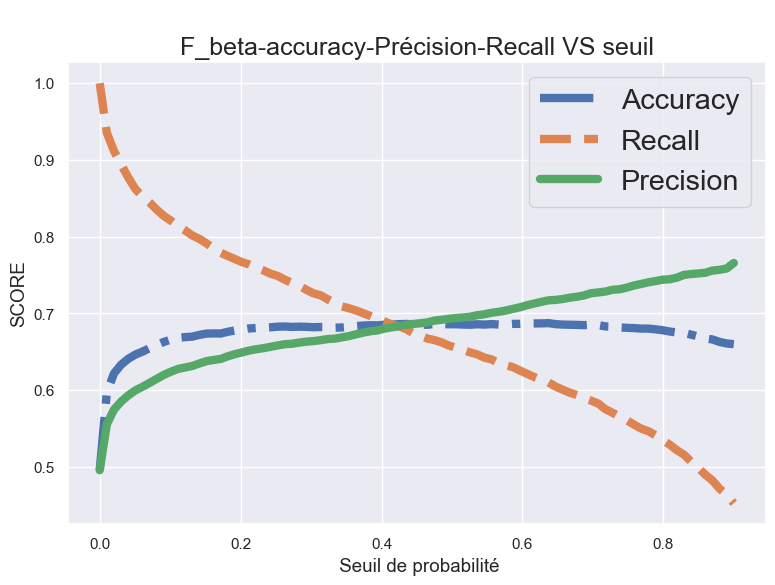

In [16]:
print_scores( Y_true= data["test_data"].labels.values , Y_proba= predict_labels.ravel() , plot_kind="apr", fig_sz=(9,6) )

In [17]:
data["test_data"].labels.values

array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

In [18]:
predict_labels.ravel()

array([0.9019315 , 0.99842715, 0.7384971 , ..., 0.04765588, 0.9886756 ,
       0.15362312], dtype=float32)

In [19]:
seuil_min = my_cost( data["test_data"].labels.values , predict_labels.ravel() , poids= 0.9 )['seuil_min'][0]
seuil_min

0.6286262626262626

In [20]:
Y_lbl_prdct = prediction_function_threshold(Y_proba=predict_labels, seuil= seuil_min ).ravel()

In [21]:
print( metrics.classification_report( data["test_data"].labels , Y_lbl_prdct ) )

              precision    recall  f1-score   support

           0       0.67      0.76      0.71      4818
           1       0.72      0.61      0.66      4738

    accuracy                           0.69      9556
   macro avg       0.69      0.69      0.69      9556
weighted avg       0.69      0.69      0.69      9556



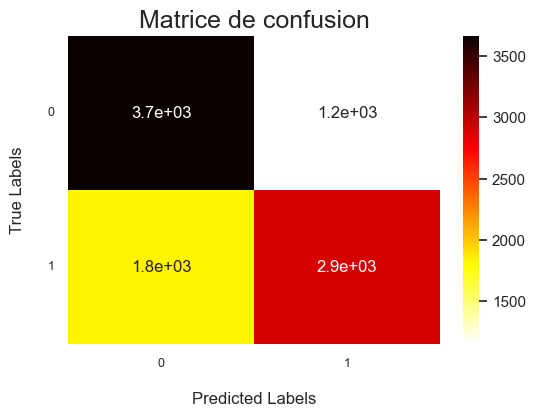

In [22]:
plot_confusion_matrix( data["test_data"].labels , Y_lbl_prdct, figsize = (6,4) )